# Uproot and Awkward Arrays

## Tutorial for Electron Ion Collider users

Jim Pivarski (Princeton University)

## Table of contents

* [Uproot: getting data](#uproot)
    - [Exploring a TFile](#Exploring-a-TFile)
    - [Exploring a TTree](#Exploring-a-TTree)
    - [Turning ROOT branches into NumPy arrays](#Turning-ROOT-branches-into-NumPy-arrays)
    - [Memory management; caching and iteration](#Memory-management;-caching-and-iteration)
    - [Jagged arrays (segue)](#Jagged-arrays-(segue))
* [Awkward Array: manipulating data](#awkward)
    - [Using Uproot data in Awkward 1.0](#Using-Uproot-data-in-Awkward-1.0)
    - [Iteration in Python vs array-at-a-time operations](#Iteration-in-Python-vs-array-at-a-time-operations)
    - [Zipping arrays into records and projecting them back out](#Zipping-arrays-into-records-and-projecting-them-back-out)
    - [Filtering (cutting) events and particles with advanced selections](#Filtering-(cutting)-events-and-particles-with-advanced-selections)
    - [Flattening for plots and regularizing to NumPy for machine learning](#Flattening-for-plots-and-regularizing-to-NumPy-for-machine-learning)
    - [Broadcasting flat arrays and jagged arrays](#Broadcasting-flat-arrays-and-jagged-arrays)
    - [Combinatorics: cartesian and combinations](#Combinatorics:-cartesian-and-combinations)
    - [Reducing from combinations](#Reducing-from-combinations)
    - [Imperative, but still fast, programming in Numba](#Imperative,-but-still-fast,-programming-in-Numba)
    - [Grafting jagged data onto Pandas](#Grafting-jagged-data-onto-Pandas)
    - [NumExpr, Autograd, and other third-party libraries](#NumExpr,-Autograd,-and-other-third-party-libraries)

<br>
<br>
<a name="uproot">
<img src="https://github.com/scikit-hep/uproot/raw/master/docs/source/logo-600px.png" width="300">

Uproot is a pure Python reimplementation of a significant part of ROOT I/O.

<br>
<img src="https://raw.githubusercontent.com/jpivarski/2019-07-29-dpf-python/master/img/abstraction-layers.png" width="700">
<br>

You can read TTrees containing basic data types, STL vectors, strings, and some more complex data, especially if it was written with a high "splitLevel".

You can also read histograms and other objects into generic containers, but the C++ methods that give those objects functionality are not available.

## Exploring a TFile

Uproot was designed to be Pythonic, so the way we interact with ROOT files is different than it is in ROOT.

In [2]:
import uproot
file = uproot.open("open_charm_18x275_10k.root")

A ROOT file may be thought of as a dict of dicts, with `keys` and `values` like a Python dict.

In [3]:
file.keys()

[b'events;1']

In [4]:
file.values()

[<ROOTDirectory b'events' at 0x7ff964c8a250>]

**What's the `b` before the name?** All strings retrieved from ROOT are unencoded, which Python 3 treats differently from Python 2. In the near future, Uproot will automatically interpret all strings from ROOT as UTF-8 and this cosmetic issue will be gone.

**What's the `;1` at the end of the name?** It's the cycle number, something ROOT uses to track multiple versions of an object. You can usually ignore it.

Nested directories are a dict of dicts.

In [5]:
file["events"].keys()

[b'tree;2', b'tree;1']

In [6]:
file["events"]["tree"]

<TTree b'tree' at 0x7ff964c67cd0>

But there are shortcuts:

   * use a `/` to navigate through the levels in a single string;
   * use `allkeys` to recursively show all keys in all directories.

In [7]:
file.allkeys()

[b'events;1', b'events/tree;2', b'events/tree;1']

In [8]:
file["events/tree"]

<TTree b'tree' at 0x7ff964ade2d0>

## Exploring a TTree

A TTree can also be thought of as a dict of dicts, this time to navigate through branches.

In [9]:
tree = file["events/tree"]
tree.keys()

[b'evt_id',
 b'evt_true_q2',
 b'evt_true_x',
 b'evt_true_y',
 b'evt_true_w2',
 b'evt_true_nu',
 b'evt_has_dis_info',
 b'evt_prt_count',
 b'evt_weight',
 b'id',
 b'pdg',
 b'trk_id',
 b'charge',
 b'dir_x',
 b'dir_y',
 b'dir_z',
 b'p',
 b'px',
 b'py',
 b'pz',
 b'tot_e',
 b'm',
 b'time',
 b'is_beam',
 b'is_stable',
 b'gen_code',
 b'mother_id',
 b'mother_second_id',
 b'has_pol_info',
 b'pol_x',
 b'pol_y',
 b'pol_z',
 b'has_vtx_info',
 b'vtx_id',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'vtx_t',
 b'has_smear_info',
 b'smear_has_e',
 b'smear_has_p',
 b'smear_has_pid',
 b'smear_has_vtx',
 b'smear_has_any_eppid',
 b'smear_orig_tot_e',
 b'smear_orig_p',
 b'smear_orig_px',
 b'smear_orig_py',
 b'smear_orig_pz',
 b'smear_orig_vtx_x',
 b'smear_orig_vtx_y',
 b'smear_orig_vtx_z']

Often, the first thing I do when I look at a TTree is `show` to see how each branch is going to be interpreted.

In [14]:
print("branch name              streamer (for complex data)  interpretation in Python")
print("==============================================================================")

tree.show()

branch name              streamer (for complex data)  interpretation in Python
evt_id                     (no streamer)              asdtype('>u8')
evt_true_q2                (no streamer)              asdtype('>f8')
evt_true_x                 (no streamer)              asdtype('>f8')
evt_true_y                 (no streamer)              asdtype('>f8')
evt_true_w2                (no streamer)              asdtype('>f8')
evt_true_nu                (no streamer)              asdtype('>f8')
evt_has_dis_info           (no streamer)              asdtype('int8')
evt_prt_count              (no streamer)              asdtype('>u8')
evt_weight                 (no streamer)              asdtype('>f8')
id                         (no streamer)              asjagged(asdtype('>u8'))
pdg                        (no streamer)              asjagged(asdtype('>i8'))
trk_id                     (no streamer)              asjagged(asdtype('>f8'))
charge                     (no streamer)              asjagged

Most of the information you'd expect to find in a TTree is there. See [uproot.readthedocs.io](https://uproot.readthedocs.io/en/latest/ttree-handling.html) for a complete list.

In [20]:
tree.numentries

10000

In [27]:
tree["evt_id"].compressedbytes(), tree["evt_id"].uncompressedbytes(), tree["evt_id"].compressionratio()

(15417, 80000, 5.189076992929882)

In [25]:
tree["evt_id"].numbaskets

3

In [26]:
[tree["evt_id"].basket_entrystart(i) for i in range(3)]

[0, 3990, 5883]

## Turning ROOT branches into NumPy arrays

There are several methods for this; they differ only in convenience.

In [30]:
# TBranch → array
tree["evt_id"].array()

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [31]:
# TTree + branch name → array
tree.array("evt_id")

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [33]:
# TTree + branch names → arrays
tree.arrays(["evt_id", "evt_prt_count"])

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64)}

In [34]:
# TTree + branch name pattern(s) → arrays
tree.arrays("evt_*")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

In [41]:
# TTree + branch name regex(s) → arrays
tree.arrays("/evt_[A-Z_0-9]*/i")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #1:** turn the bytestrings into real strings (will soon be unnecessary).

In [42]:
tree.arrays("evt_*", namedecode="utf-8")

{'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #2:** output a tuple instead of a dict.

In [44]:
tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 array([51, 26, 27, ..., 42, 25, 11], dtype=uint64))

... to use it in assignment:

In [45]:
evt_id, evt_prt_count = tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

In [46]:
evt_id

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

## Memory management; caching and iteration

The `array` methods read an entire branch into memory. Sometimes, you might not have enough memory to do that.

The simplest solution is to set `entrystart` (inclusive) and `entrystop` (exclusive) to only read a batch at a time.

In [47]:
tree.array("evt_id", entrystart=500, entrystop=600)

array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599], dtype=uint64)

Uproot is not agressive about caching: if you call `arrays` many times (for many small batches), it will read from the file every time.

You can avoid frequent re-reading by assigning arrays to variables, but then you'd have to manage many variables.

Instead, use caching:

In [49]:
# Make a cache with an acceptable limit.
gigabyte_cache = uproot.ArrayCache("1 GB")

# Read the array from disk:
tree.array("evt_id", cache=gigabyte_cache)

# Get the array from the cache:
tree.array("evt_id", cache=gigabyte_cache)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

The advantage is that the same code can be used for first time and subsequent times. You can put this in a loop.

Naturally, fetching from the cache is much faster than reading from disk (though our file isn't very big!).

In [55]:
%%timeit

tree.arrays("*")

564 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit

tree.arrays("*", cache=gigabyte_cache)

2.07 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The value of an explicit cache is that you get to control it.

In [58]:
len(gigabyte_cache)

52

In [59]:
gigabyte_cache.clear()

In [60]:
len(gigabyte_cache)

0

Setting `entrystart` and `entrystop` can get annoying; we probably want to do it in a loop.

There's a method, `iterate`, for that.

In [61]:
for arrays in tree.iterate("evt_*", entrysteps=1000):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id'

In [63]:
for arrays in tree.iterate("evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

In [64]:
for arrays in tree.iterate("evt_id", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 10000}


This `TTree.iterate` method is similar in form to the `uproot.iterate` function, which iterates in batches over a collection of files.

In [66]:
for arrays in uproot.iterate(["open_charm_18x275_10k.root",
                              "open_charm_18x275_10k.root",
                              "open_charm_18x275_10k.root"], "events/tree", "evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

## Jagged arrays (segue)

Most of the branches in this file have an "asjagged" interpretation.

In [67]:
tree["pdg"].interpretation

asjagged(asdtype('>i8'))

This means that they have multiple values per entry.

In [68]:
tree["pdg"].array()

<JaggedArray [[11 211 -211 ... 22 22 22] [11 211 -211 ... -211 22 22] [11 2112 2212 ... 22 22 -211] ... [11 -211 321 ... 22 22 22] [11 2112 -211 ... 22 22 130] [11 -211 -321 ... 130 22 22]] at 0x7ff964e568d0>

Jagged arrays (lists of variable-length sublists) are very common in particle physics, and surprisingly uncommon in other fields.

We need them because we almost always have a variable number of particles per event.

In [126]:
from particle import Particle     # https://github.com/scikit-hep/particle

counter = 0
for event in tree["pdg"].array():
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

51 particles: e- pi+ pi- K- pi+ pi- pi- pi+ pi+ pi+ gamma gamma K(L)0 K+ pi- K(L)0 gamma gamma gamma gamma pi+ pi- pi+ gamma gamma p pi- pi+ K+ pi- pi- K+ K- gamma gamma pi+ pi- K+ pi- pi+ K(L)0 K(L)0 gamma gamma pi+ pi- pi+ gamma gamma gamma gamma
26 particles: e- pi+ pi- n~ n gamma pi- pi+ gamma gamma pi+ gamma gamma gamma gamma gamma K(L)0 gamma gamma gamma gamma pi- pi+ pi- gamma gamma
27 particles: e- n p pi+ pi+ pi+ pi- pi- pi- pi- pi- pi+ pi- gamma gamma gamma pi+ K+ K- pi+ gamma gamma gamma gamma gamma gamma pi-
28 particles: e- pi+ pi- nu(mu) mu+ gamma gamma pi- pi+ n gamma gamma n pi- p~ pi+ gamma gamma pi+ pi- K- K(L)0 gamma gamma gamma gamma gamma gamma
30 particles: e- pi+ pi- pi+ pi- n gamma gamma K- pi+ n pi- pi+ gamma n~ p~ pi+ K(L)0 gamma gamma pi- gamma gamma pi- pi+ gamma gamma K+ pi- gamma
12 particles: e- gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma
25 particles: pi- K- K+ pi- gamma gamma pi- gamma gamma pi- K(L)0 K(L)0 gamma gamma gamma gamma 

Although you can iterate over jagged arrays with for loops, the idiomatic and faster way to do it is with array-at-a-time functions.

In [80]:
vtx_x, vtx_y, vtx_z = tree.arrays(["vtx_[xyz]"], outputtype=tuple)

In [81]:
import numpy as np

vtx_dist = np.sqrt(vtx_x**2 + vtx_y**2 + vtx_z**2)
vtx_dist

<JaggedArray [[0.010869109735358505 0.04461569970007986 0.018400738439694277 ... 3.1836758411592023 3.183642553033989 3.183642553033989] [0.00044890687568113205 0.03373796683736145 0.05401859969095815 ... 131.99585878615915 0.028563725689861715 0.028563725689861715] [0.036756813467945904 4.486285131592035e-10 0.04416327313376598 ... 1.2533205300290502 1.2533205300290502 0.5367743154487575] ... [0.008254781290207314 0.01227106989388853 0.018030435962753534 ... 2.5798363404850953e-05 1.3027315899452183 1.3027315899452183] [0.0007829175274973732 4.5649022026043563e-10 0.00177464214391142 ... 0.00013687824404269707 0.00013687824404269707 8.543815169675133] [0.03541578165022657 0.002674912324039225 0.008526111534115434 ... 0.36799639096494413 0.3687648973563558 0.3687648973563558]] at 0x7ff933008f10>

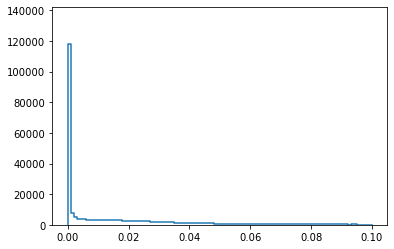

In [84]:
import matplotlib.pyplot as plt
import mplhep as hep             # https://github.com/scikit-hep/mplhep
import boost_histogram as bh     # https://github.com/scikit-hep/boost-histogram

vtx_hist = bh.Histogram(bh.axis.Regular(100, 0, 0.1))
vtx_hist.fill(vtx_dist.flatten())
hep.histplot(vtx_hist)

In [85]:
vtx_dist > 0.01

<JaggedArray [[True True True ... True True True] [False True True ... True True True] [True False True ... True True True] ... [False True True ... False True True] [False False False ... False False True] [True False False ... True True True]] at 0x7ff933024c50>

In [86]:
pdg = tree["pdg"].array()
pdg[vtx_dist > 0.01]

<JaggedArray [[11 211 -211 ... 22 22 22] [211 -211 -211 ... -211 22 22] [11 2212 211 ... 22 22 -211] ... [-211 321 -321 ... -211 22 22] [211 -211 211 ... 211 -211 130] [11 2112 -211 ... 130 22 22]] at 0x7ff932f947d0>

In [125]:
counter = 0
for event in pdg[vtx_dist > 0.10]:
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

16 particles: p pi- K+ pi- pi- pi+ pi- pi+ K(L)0 pi+ pi- pi+ gamma gamma gamma gamma
9 particles: pi- pi+ K(L)0 gamma gamma gamma gamma pi+ pi-
8 particles: pi- pi- K+ K- pi+ gamma gamma pi-
7 particles: nu(mu) mu+ pi+ pi- K- gamma gamma
8 particles: K- pi+ p~ pi+ pi- pi+ K+ pi-
6 particles: gamma gamma gamma gamma gamma gamma
2 particles: K- K(L)0
1 particles: n
0 particles: 
12 particles: K- pi+ pi- K(L)0 pi- pi+ gamma gamma gamma gamma gamma gamma
7 particles: pi+ pi- K(L)0 pi+ K- gamma gamma
10 particles: pi+ pi- nu(e)~ e- K+ K(L)0 gamma gamma gamma gamma
11 particles: n pi+ K- gamma gamma gamma gamma p~ pi+ pi+ pi-
6 particles: K+ pi+ pi- pi- gamma gamma
16 particles: pi- pi- pi+ gamma gamma pi- K- pi+ pi+ pi- gamma gamma gamma gamma gamma gamma
6 particles: K+ pi- gamma gamma gamma gamma
10 particles: pi- pi+ p~ e+ e- gamma gamma gamma gamma gamma
18 particles: n pi- n~ pi+ n pi+ pi- pi+ pi- p pi- n~ pi+ pi+ gamma gamma gamma gamma
11 particles: nu(e) e+ K- K+ pi- pi+ pi- gamma g

In [119]:
Particle.from_string("p~")

<Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>

In [120]:
int(Particle.from_string("p~").pdgid)

-2212

In [123]:
is_antiproton = (pdg == int(Particle.from_string("p~").pdgid))
is_antiproton

<JaggedArray [[False False False ... False False False] [False False False ... False False False] [False False False ... False False False] ... [False False False ... False False False] [False False False ... False False False] [False False False ... False False False]] at 0x7ff92c740690>

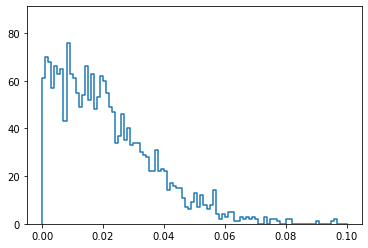

In [124]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 0.1)).fill(vtx_dist[is_antiproton].flatten()))

<br>
<br>
<a name="awkward">
<img src="https://github.com/scikit-hep/awkward-1.0/raw/master/docs-images/logo/logo-600px.png" width="400">

## Using Uproot data in Awkward 1.0

## Iteration in Python vs array-at-a-time operations

## Zipping arrays into records and projecting them back out

## Filtering (cutting) events and particles with advanced selections

## Flattening for plots and regularizing to NumPy for machine learning

## Broadcasting flat arrays and jagged arrays

## Combinatorics: cartesian and combinations

## Reducing from combinations

## Imperative, but still fast, programming in Numba

## Grafting jagged data onto Pandas

## NumExpr, Autograd, and other third-party libraries